<div class="alert alert-block alert-info">
Python code used to produce Fig. 1 from:<br>
Vettoretti, G. Ditlevsen, P., Jochum, M. and Rasmussen, S. O., Atmospheric CO$_2$ Control of Spontaneous Millennial-Scale Ice Age Climate Oscillations. <i>Nature Geocience</i> (2022).</div>


In [1]:
import os
import fnmatch

import numpy as np

from scipy.stats import linregress

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

# netcdf and time utils
from netCDF4 import Dataset
import cftime

# data processing and timeseries analysis (reading .nc and .xls)
import xarray as xr
import pandas as pd

# to load matlab files
from mat4py import loadmat

# empircal mode decomposiion
# https://pyemd.readthedocs.io/en/latest/intro.html
from PyEMD import CEEMDAN

In [2]:
# inward plotting ticks
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
# set the font globally
rcParams.update({'font.family':'sans-serif'})
rcParams.update({'font.sans-serif':'Arial'})

#### Define some useful functions

In [3]:
def setaxesfsize(axl,fontsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
#    i=0
    for labely in ticklabelleft:
#        if i != 0:
            labely.set_fontsize(fontsize)

In [4]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [5]:
def detrend_common(y, order=1):
    '''detrend multivariate series by common trend

    Paramters
    ---------
    y : ndarray
       data, can be 1d or nd. if ndim is greater then 1, then observations
       are along zero axis
    order : int
       degree of polynomial trend, 1 is linear, 0 is constant

    Returns
    -------
    y_detrended : ndarray
       detrended data in same shape as original 

    '''
    nobs = y.shape[0]
    shape = y.shape
    y_ = y.ravel()
    nobs_ = len(y_)
    t = np.repeat(np.arange(nobs), nobs_ /float(nobs))
    exog = np.vander(t, order+1)
    params = np.linalg.lstsq(exog, y_, rcond=None)[0]
    fittedvalues = np.dot(exog, params)
    resid = (y_ - fittedvalues).reshape(*shape)
    return resid, params



In [6]:
def add_arrows(line, interval=None, size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    datapts = xdata.shape[0]
    #print(datapts)
    startlist = np.linspace(interval/2, datapts-interval/2, interval).astype(int)
    #print(startlist)
    endlist = startlist + 1
    for i in range(len(startlist)):
        line.axes.annotate('',
            xytext=(xdata[startlist[i]], ydata[startlist[i]]),
            xy=(xdata[endlist[i]], ydata[endlist[i]]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )

In [7]:
# Where is the data directory
datadir = "./data/"

In [8]:
!ls $datadir

antarctica2015co2.xls
GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_2014_v19Nov2014.xlsx
GIfraction.mat
GIfraction.txt
Pedro_QSR2018_fig1a.txt
Pedro_QSR2018_fig1b.txt
WAIS_Divide_MIS3_CO2.xlsx


In [9]:
# read in Excel data, CO2 , calcium
co2data = pd.ExcelFile(datadir+"antarctica2015co2.xls")
caldata = pd.ExcelFile(datadir+"GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_2014_v19Nov2014.xlsx")

In [10]:
# we have updated to using Buska 2021 CO2 data
co2data_B2021 = pd.ExcelFile(datadir+"WAIS_Divide_MIS3_CO2.xlsx")
#co2readme_B2021 = co2data_B2021.parse("Sheet1")
#co2readme_B2021.head(10)

In [11]:
# we have updated to using Buska 2021 CO2 data
#co2vals_B2021 = co2data_B2021.parse('Sheet1', header=12, names=['(meters)','Blank Corrected','Gravity & Blank Corrected','Standard Error','WD2014 Age (Years BP 1950)'])
co2vals_B2021 = co2data_B2021.parse('Sheet1', header=12)

/home/guido/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
# read in Joel's data (ATS stack etc.)
jpfig1adat = pd.read_csv(datadir+"Pedro_QSR2018_fig1a.txt", sep='\t', header=None)
jpfig1bdat = pd.read_csv(datadir+"Pedro_QSR2018_fig1b.txt", sep='\t', header=None)

In [13]:
jpfig1adat.columns = ["Time (years BP)", "NGRIP Temperature"]
jpfig1bdat.columns = ["Time (years BP)", "Antarctic Temperature"]

In [14]:
# read in the old CO2 data
co2vals = co2data.parse("CO2 Composite", header=14, names=['Gasage (yr BP)', 'CO$_2$', 'sigma mean CO2 (ppmv)'])

In [15]:
co2imfdatax = co2vals[620:915]['Gasage (yr BP)'].values
co2imfdatay = co2vals[620:915]['CO$_2$'].values

In [16]:
# Resample data on same scale for each variable 
co2x_rs=np.linspace(20000, 60000, 4001)
co2y_rs=np.interp(co2x_rs, co2imfdatax, co2imfdatay)

In [17]:
# look at some EMD of co2
ceemdan = CEEMDAN()
cIMFs = ceemdan(co2y_rs)

In [18]:
# look at the detrended CO2 data
co2_dt_res , co2_dt_par = detrend_common(co2y_rs)

In [19]:
co2_dt_par

array([9.46513813e-03, 1.83592025e+02])

In [20]:
#'Time (years BP)', y='NGRIP Temperature'
ngrip_time = jpfig1adat['Time (years BP)'].values
ngrip_temp = jpfig1adat['NGRIP Temperature'].values
aats_time = jpfig1bdat['Time (years BP)'].values
aats_temp = jpfig1bdat['Antarctic Temperature'].values

In [21]:
# resample the data onto equally spaced timeseries

ngrip_x_rs=np.linspace(20000, 60000, 4001) #every 10 years
ngrip_y_rs=np.interp(ngrip_x_rs,ngrip_time , ngrip_temp)

aats_x_rs=np.linspace(20000, 60000, 4001) #every 10 years
aats_y_rs=np.interp(aats_x_rs,aats_time , aats_temp)


In [22]:
# do an EMD on the data
ceemdan = CEEMDAN()
ngrip_cIMFs = ceemdan(ngrip_y_rs)
aats_cIMFs = ceemdan(aats_y_rs)

In [23]:
# add up the IMFs to get a smoothed curve
ngrip_smooth = (ngrip_cIMFs[3]+ngrip_cIMFs[4]+ngrip_cIMFs[5]+ngrip_cIMFs[6]+ngrip_cIMFs[7])[::-1] # reverse timeseries
ngrip_time_new = -ngrip_x_rs[::-1]
co2_newtime = -co2x_rs[::-1]

In [24]:
# add up the IMFs to get a smoothed curve
aats_smooth = (aats_cIMFs[3]+aats_cIMFs[4]+aats_cIMFs[5]+aats_cIMFs[6]+aats_cIMFs[7])[::-1] # reverse timeseries
aats_time_new = -aats_x_rs[::-1]

In [25]:
ngrip_cum_window = np.array([ np.sum(ngrip_smooth[i:i+1000]) for i in range(ngrip_smooth.shape[0]-1000) ])

In [26]:
# calculate a time fraction that we are in a stadial or interstadial, data is in 10 year increments
def rolling_timefrac_calc(nsdata, windowlen):
    timefrac = []
    for i in range(nsdata.shape[0] - windowlen):
        dtmp = nsdata[i:i + windowlen]
        dtmp_time = np.where(dtmp >= 0.0, 10.0, -10.0)
        dtmp_sum = np.sum(dtmp_time)
        dtmp_norm = dtmp_sum/(windowlen*10.0)
        timefrac.append(dtmp_norm)
    
    return np.array(timefrac)

In [27]:
ngrip_timefrac = rolling_timefrac_calc(ngrip_smooth - np.mean(ngrip_smooth), 1000) # not used

In [28]:
# smooth the NGRIP and ATS data using the imperical mode functions from EMD.
ngrip_smooth = np.sum(ngrip_cIMFs[3:9], axis=0)[::-1] # reverse timeseries|
aats_smooth =  np.sum(aats_cIMFs[3:9], axis=0)[::-1]# reverse timeseries

#### load up CCSM4 glacial climate data from local store

In [29]:
# For access to this data go to: https://sid.erda.dk/cgi-sid/ls.py?share_id=Fo2F7YWBmv 
awrkdir=["/mdata/climo/cesmi6gat31rblc210p05fwf/atm/hist/ts/"] # D-O run , co2=210 ppmv FWF 500 x 0.05 Sv
case="cesmi6gat31rblc210p05fwf"
season = "ANN"

In [30]:
# load up CCSM4 Pre-Industrial climate data from local store

# For access to this data go to: https://sid.erda.dk/cgi-sid/ls.py?share_id=Fo2F7YWBmv 
mod_awrkdir=["/mdata/climo/cesmpit31rbl/atm/hist/ts/"] # do run , co2=210 ppmv FWF 500 x 0.05 Sv
mod_case="cesmpit31rbl"
season = "ANN"

In [31]:
afiles=[]
for wd in awrkdir:
    print(wd)
    for file in os.listdir(wd):
        if fnmatch.fnmatch(file, 'cesm*'+season+'_??????_??????_cam2_decclimots.nc'):
            afiles.append(wd+file)

/mdata/climo/cesmi6gat31rblc210p05fwf/atm/hist/ts/


In [32]:
mod_afiles=[]
for wd in mod_awrkdir:
    print(wd)
    for file in os.listdir(wd):
        if fnmatch.fnmatch(file, 'cesm*'+season+'_???_??????_cam2_decclimots.nc'):
            mod_afiles.append(wd+file)

/mdata/climo/cesmpit31rbl/atm/hist/ts/


In [33]:
axrdata = xr.open_dataset(afiles[0], engine='netcdf4', chunks={'time': 10})

In [34]:
mod_axrdata = xr.open_dataset(mod_afiles[0], engine='netcdf4', chunks={'time': 10})

#### get the data for the single point location from Greenland and Antarctica in the coupled model

In [35]:
ngrip = (75.10, -42.32)
def get_latlon_idx(coord):
    x_lat = axrdata["lat"].sel(lat = slice(coord[0] - 2,coord[0] + 2)).values
    if coord[1] >= 0.0:
        x_lon = axrdata["lon"].sel(lon = slice(coord[1] - 2.0,coord[1] + 2.0)).values
    else:
        x_lon = axrdata["lon"].sel(lon = slice(360.0+coord[1] - 2.0,360.0 + coord[1] + 2.0)).values
    print(x_lat, x_lon)
    x_lat_idx = np.where(axrdata["lat"].values == x_lat[0])[0]
    x_lon_idx = np.where(axrdata["lon"].values == x_lon[0])[0]
    return x_lat_idx[0], x_lon_idx[0]


In [36]:
lldata = get_latlon_idx(ngrip)

[76.07024446] [318.75]


In [37]:
ngrip_temp = axrdata.TS.isel(lat = lldata[0], lon=lldata[1]) - 273.15

In [38]:
# now do the temperature at ice core 1x1 deg model locations
# need to add Bo's locations in.
#DYE-3: 65.18N, 43.83W
#Renland: 71.27N, 26.23W
#GRIP: 72.58N, 37.64W
#GISP2: 72.60N, 38.50W
#NGRIP: 75.10N, 42.32W
#Camp Century: 77.18N, 61.11W
#NEEM: 77.45, 51.06W

# lat, lon
dye3 = (65.18, -43.83)
renland = (71.27, -26.23)
grip = (72.58, -37.64)
gisp2 = (72.60, -38.50)
ngrip = (75.10, -42.32)
campcentury = (77.18, -61.11)
neem = (77.45, -51.06)


In [39]:
#ATS_core_locations
#EDC: 75.0S; 123.1E
#DF: 77.2S; 39.4E
#Vostok: 77.3S; 106.0.E
# TaldICE: 72.5S, 159.0E
# EDML: 75.0S, 0.0E
# WDC: 79.3S, 112W

# lat, lon
edml = (-75.0, 0.0)
df = (-77.2, 39.4)
vostok = (-77.3, 106.0)
edc = (-75.0, 123.1)
taldice = (-72.5, 159.0)
wdc = (-79.3, -112)

ats_cores = [ edml, df, vostok, edc, taldice, wdc]

In [40]:
ats_ll_idx = [ get_latlon_idx(ats_cores[i]) for i in range(6)]

[-76.07024446] [0.]
[-76.07024446] [37.5  41.25]
[-76.07024446] [105.]
[-76.07024446] [123.75]
[-72.36158103] [157.5]
[-79.77704565] [247.5]


In [41]:
mod_ats_temp = [ mod_axrdata.TS.isel(lat = ats_ll_idx[i][0], lon=ats_ll_idx[i][1]) for i in range(6) ]

In [42]:
ats_temp = [ axrdata.TS.isel(lat = ats_ll_idx[i][0], lon=ats_ll_idx[i][1]) for i in range(6) ]

In [43]:
mod_ats_mean = [ np.average(mod_ats_temp[i][-100:-1]) for i in range(6) ]

In [44]:
ats_stack = [ ats_temp[i] - mod_ats_mean[i] for i in range(6) ]

In [45]:
ats_mean_temp = (ats_stack[0] + ats_stack[1] + ats_stack[2] +  ats_stack[3] + ats_stack[4] + ats_stack[5])/6.0 

In [46]:
model_ngrip_cIMFs = ceemdan(ngrip_temp.values)
model_aats_cIMFs = ceemdan(ats_mean_temp.values)

In [47]:
model_ngrip_smooth = np.sum(model_ngrip_cIMFs[3:8], axis=0) # reverse timeseries
model_aats_smooth =  np.sum(model_aats_cIMFs[3:7], axis=0)# reverse timeseries


#### load S.R data 

In [48]:
# S.R calculated fractional time in the interstadial offline using MATLAB.
# G.V did the calculation above also, but used S.R data.

sune_data = loadmat('GIfraction.mat')
sune_gifrac = np.array(sune_data['GIfraction'])

#### go back to the new Buska CO2 data


In [49]:
co2imfdatax_B2021 = co2vals_B2021[300:632]['WD2014 Age (Years BP 1950)'].values
co2imfdatay_B2021 = co2vals_B2021[300:632]['Gravity & Blank Corrected'].values
# Resample data on same scale for each variable 
co2x_rs_B2021=np.linspace(20000, 60000, 4001)
co2y_rs_B2021=np.interp(co2x_rs_B2021, co2imfdatax_B2021, co2imfdatay_B2021)
# detrend
co2_dt_res_B2021 , co2_dt_par_B2021 = detrend_common(co2y_rs_B2021)
res_B2021 = linregress(co2x_rs_B2021, co2y_rs_B2021)
cIMFs_B2021 = ceemdan(co2y_rs_B2021)

#### Now produce Figure 1 for the paper

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


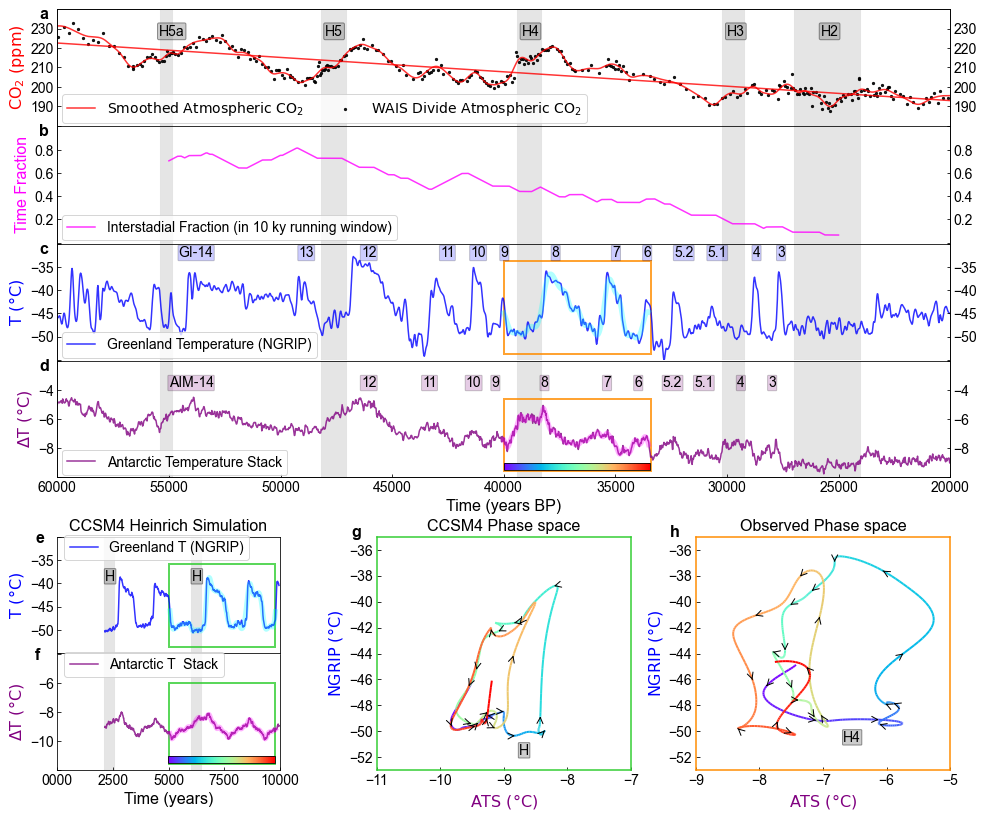

In [50]:
# Using J.P's (T data), S.R's (timefraction), T.B's (CO2) and G.V's model data
fig = plt.figure(figsize=(16,14))

############## Set up grid spec axes

gs = gridspec.GridSpec(130, 140)

# widths
#x1 = 0
#x2 = 106
#x3 = 115
#x4 = 140
x1 = 0
x2 = 140

# left timeseries panels
ax0 = plt.subplot(gs[0:20, x1:x2])
ax1 = plt.subplot(gs[20:40, x1:x2])
ax2 = plt.subplot(gs[40:60, x1:x2])
ax3 = plt.subplot(gs[60:80, x1:x2])
ax4 = plt.subplot(gs[80:90, x1:x2])
# heinrich model 

x3 = 0
x4 = 35
ax5 = plt.subplot(gs[90:110, x3:x4])
ax6 = plt.subplot(gs[110:130, x3:x4])

x5 = 50
x6 = 90
x7 = 100
x8 = 140
ax7 = plt.subplot(gs[90:130, x5:x6])
ax8 = plt.subplot(gs[90:130, x7:x8])

ax = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# right side labels
axr = [ ax[0].twinx(), ax[1].twinx(), ax[2].twinx(), ax[3].twinx()]

###################################################################

# timeseries line thickness
tslw = 1.5
tsalp = 0.8
#co2vals_B2021.plot(ax = ax[0], x='WD2014 Age (Years BP 1950)', y='Gravity & Blank Corrected', color='red', alpha=0.7)
# use Busaka 2021
co2vals_B2021.plot.scatter(ax = ax[0], x='WD2014 Age (Years BP 1950)', y='Gravity & Blank Corrected', color='black',s=5, alpha=0.9, label='WAIS Divide Atmospheric CO$_2$')
ax[0].plot(co2x_rs_B2021, np.sum(cIMFs_B2021[4:8], axis=0), color='red',alpha=tsalp, linewidth=tslw, label='Smoothed Atmospheric CO$_2$')

# add in linear CO2 trend
#ax[0].plot(co2x_rs, co2y_rs - co2_dt_res, color='red', alpha=tsalp , linewidth=tslw )
# use new Busaka 2021
ax[0].plot(co2x_rs_B2021, co2y_rs_B2021 - co2_dt_res_B2021, color='red', alpha=tsalp , linewidth=tslw )
#set co2 ticks
yticks=[180., 190., 200., 210., 220., 230.]
ax[0].set_yticks(yticks)
axr[0].set_yticks(yticks)
#set co2 labels
ylabels=["","190","200","210","220","230"]
ax[0].set_yticklabels(ylabels)
axr[0].set_yticklabels(ylabels)

#ax[1].plot(ngrip_time_new[500:-500], ngrip_timefrac, color='magenta', alpha=tslw , linewidth=tsalp, label="Interstadial (+) / Stadial (-) Persistence" )
# use Sune's data
ax[1].plot(-sune_gifrac[25000:55000,0], sune_gifrac[25000:55000,2], color='magenta', alpha=tsalp , linewidth=tslw, label="Interstadial Fraction (in 10 ky running window)" )

jpfig1adat.plot(ax = ax[2], x='Time (years BP)', y='NGRIP Temperature', style='-',
                label='Greenland Temperature (NGRIP)', color='blue', alpha=tsalp, linewidth=tslw )
jpfig1bdat.plot(ax = ax[3], x='Time (years BP)', y='Antarctic Temperature', style='-',
                color='purple', alpha=tsalp, linewidth=tslw , label='Antarctic Temperature Stack')

ax[0].set_ylabel("CO$_2$ (ppm)", size=16, color='red')
ax[1].set_ylabel("Time Fraction", size=16, color='magenta')
ax[2].set_ylabel("T ($\degree$C)", size=16, color='blue')
ax[3].set_ylabel("$\Delta$T ($\degree$C)", size=16, color='purple')
ax[3].set_xlabel("Time (years BP)", size=16)

xmax = 60000
xmin = 20000
# shift the axes
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(180,240)
ax[0].invert_xaxis()

ax[1].set_xlim(-xmax, -xmin)
#ax[1].set_ylim(-1.0,1.0)
ax[1].set_ylim(0,1.0)
#ax[1].invert_xaxis()

ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(-55, -30)
ax[2].invert_xaxis()

ax[3].set_xlim(xmin, xmax)
ax[3].set_ylim(-10,-2)
ax[3].invert_xaxis()

############################################
# put numbers on right axis

tickdir = 'outward'
for loc, spine in ax[0].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    # leave top number
    elif loc in ['top']:
    #    pass
    #    #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)
for loc, spine in axr[0].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    # leave top number
    elif loc in ['top']:
    #    pass
    #    #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)

for loc, spine in ax[1].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)
for loc, spine in axr[1].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)

for loc, spine in ax[2].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)
for loc, spine in axr[2].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        #spine.set_color('black')
        spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)

for loc, spine in ax[3].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        spine.set_color('black')
        #spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)
for loc, spine in axr[3].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        spine.set_color('black')
        #spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)

# CO2 axes
axr[0].set_ylim(ax[0].get_ylim())
ticklabelleft = ax[0].get_yticklabels()
ticklabelright = axr[0].get_yticklabels()
ax[0].axes.get_xaxis().set_visible(False)
setaxesfsize(ax[0], 14)
setaxesfsize(axr[0], 14)

for j in range(1,4):
    axr[j].set_ylim(ax[j].get_ylim())
    ticklabelleft = ax[j].get_yticklabels()
    ticklabelright = axr[j].get_yticklabels()
    i=0
    for labely in ticklabelleft:
        if i == 0:
            labely.set_visible(False)
        i+=1
    labely.set_visible(False)
    if j !=3:
        ax[j].axes.get_xaxis().set_visible(False)

    setaxesfsize(ax[j], 14)
    i=0
    for labely in ticklabelright:
        if i == 0:
            labely.set_visible(False)
        i+=1
    labely.set_visible(False)
    if j !=3:
        axr[j].axes.get_xaxis().set_visible(False)

    setaxesfsize(axr[j], 14)


for j in range(0,4):
    # H and D-O labels
    # H Events
    hxlocp = [55400, 48200, 39400, 30200, 27000]
    hxlocm = [-55400, -48200, -39400, -30200, -27000]
    hwidthp = [-600, -1200, -1100, -1000, -3000]
    hwidthm = [600, 1200, 1100, 1000, 3000]
    hypos = [179.8, 0.0, -55.1, -10]
    hyh = [60, 1.0, 25.2, 8]
    hxloc = hxlocp
    hwidth = hwidthp
    if j == 0 or j == 2 or j == 3:
        hxloc = hxlocp
        hwidth = hwidthp
    else:
        hxloc = hxlocm
        hwidth = hwidthm
    for k in range(5):
        ax[j].add_patch(FancyBboxPatch((hxloc[k], hypos[j]),
                                    width=hwidth[k], height=hyh[j], clip_on=False,
                                    boxstyle="square,pad=0", zorder=0, lw=0.1,
                                    facecolor='black', alpha=0.1))

halpha=0.4
hypos = 225 # co2 axis 
hlabels = ["H5a", "H5", "H4", "H3", "H2"]
hxpos = [54300, 47200, 38400, 29200, 25000]
for i in range(0,5):
    ax[0].annotate(
            hlabels[i], 
            xy = (hxpos[i], hypos), xytext = (0, 0),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.1', fc = 'grey', alpha = halpha),
            fontsize=14)
doevents=[53000,48500,45700,42200,40800,39800,37500,34800,33400,31500,30000,28500,27400]
dolabels=["GI-14","13","12","11","10","9","8","7","6","5.2","5.1","4","3"]
for i in range(len(doevents)):
    ax[2].annotate(
        dolabels[i], 
        xy = (doevents[i], -33.5), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'blue', alpha = 0.2),
        fontsize=14) 
aimevents=[53000,45700,43000,41000,40200,38000,35200,33800,32000,30600,29200,27800]
aimlabels=["AIM-14","12","11","10","9","8","7","6","5.2","5.1","4","3"]
for i in range(len(aimevents)):
    ax[3].annotate(
        aimlabels[i], 
        xy = (aimevents[i], -4), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'purple', alpha = 0.2),
         fontsize=14) 

legsize=14
ax[0].legend(loc=(0.005,0.02), fontsize=legsize, ncol=2)
ax[1].legend(loc=(0.005,0.02), fontsize=legsize)
ax[2].legend(loc=(0.005,0.02), fontsize=legsize)
ax[3].legend(loc=(0.005,0.02), fontsize=legsize)
#ax[1].axhline(0,0,1, color='k', linewidth=0.5, ls='-.')

# ##########################
# Do Heinrich Model Plot

# get rid of dummy plot at location (just need whitespace)
ax[4].set_axis_off() 
timemean = 5 # 100 year running mean
ngrip_temp.rolling(time=timemean, center=True).mean().dropna("time").plot(ax = ax[5], label='Greenland T (NGRIP)', color='blue', alpha=tsalp, linewidth=tslw )
ats_mean_temp.rolling(time=timemean, center=True).mean().dropna("time").plot(ax = ax[6], color='purple', alpha=tsalp, linewidth=tslw , label='Antarctic T  Stack')

for loc, spine in ax[5].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        spine.set_color('black')
        #spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)
for loc, spine in ax[6].spines.items():
    if loc in ['left']:
        spine.set_position((tickdir,0)) # outward by 10 points
        spine.set_color('k')
    elif loc in ['bottom']:
        #spine.set_position(('outward',50)) # outward by 10 points
        spine.set_color('black')
        #spine.set_color('none') # don't draw spine
    elif loc in ['top']:
        spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    elif loc in ['right']:
        #spine.set_color('none') # don't draw spine
        spine.set_position((tickdir,0)) # outward by 10 points
    else:
        raise ValueError('unknown spine location: %s'%loc)


xmin = cftime.num2date(0*365, 'days since 0000-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(10000*365, 'days since 0000-01-01 00:00:00', calendar='noleap')
ax[5].set_xlim(xmin, xmax)
ax[5].set_ylim(-55, -30)
ax[6].set_xlim(xmin, xmax)
ax[6].set_ylim(-12,-4)

ax[5].set_ylabel("T ($\degree$C)", size=16, color='blue')
ax[6].set_ylabel("$\Delta$T ($\degree$C)", size=16, color='purple')
ax[6].set_xlabel("Time (years)", size=16)
legsize=14
ax[5].legend(loc=(0.03,0.8), fontsize=legsize)
ax[6].legend(loc=(0.03,0.8), fontsize=legsize)

ax[5].set_title("CCSM4 Heinrich Simulation", size=16)
ax[6].set_title("")

halpha=0.4
hypos = -40 # temp axis 
hlabels = ["H", "H"]
h0time = cftime.num2date(2600*365, 'days since 0000-01-01 00:00:00', calendar='noleap')
h1time = cftime.num2date(6500*365, 'days since 0000-01-01 00:00:00', calendar='noleap')

hxpos = [h0time, h1time]
for i in range(0,2):
    ax[5].annotate(
            hlabels[i], 
            xy = (hxpos[i], hypos), xytext = (0, 0),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.05', fc = 'grey', alpha = halpha),
            fontsize=14)
ax[5].add_patch(FancyBboxPatch((0.21, 0.00),
                        width=.05, height=1.0, clip_on=False,
                        boxstyle="square,pad=0", zorder=0, lw=0.1,
                        facecolor='black', alpha=0.1,
                        transform=ax[5].transAxes))
ax[5].add_patch(FancyBboxPatch((0.6, 0.00),
                        width=.05, height=1.0, clip_on=False,
                        boxstyle="square,pad=0", zorder=0, lw=0.1,
                        facecolor='black', alpha=0.1,
                        transform=ax[5].transAxes))
ax[6].add_patch(FancyBboxPatch((0.21, 0.00),
                        width=.05, height=1.0, clip_on=False,
                        boxstyle="square,pad=0", zorder=0, lw=0.1,
                        facecolor='black', alpha=0.1,
                        transform=ax[6].transAxes))
ax[6].add_patch(FancyBboxPatch((0.6, 0.00),
                        width=.05, height=1.0, clip_on=False,
                        boxstyle="square,pad=0", zorder=0, lw=0.1,
                        facecolor='black', alpha=0.1,
                        transform=ax[6].transAxes))


### Now add phase portraits

# what part of the timeseries to take
mts = 295 #model start
mte = 770 #model end
ots = 2000 #obs start
ote = 2650 #obs end

mod_phase_col = 'limegreen'
obs_phase_col = 'darkorange'


# add in color change due to time
colmap = plt.cm.rainbow

otime0 = ngrip_time_new[ots]
otime1 = ngrip_time_new[ote]
points = np.array([aats_smooth[ots:ote], ngrip_smooth[ots:ote]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(otime0, otime1)
lc = LineCollection(segments, cmap=colmap, norm=norm)
# Set the values used for colormapping
lc.set_array(ngrip_time_new[ots:ote])
lc.set_linewidth(2)
line = ax[8].add_collection(lc)
# now model

mtime0 = ngrip_temp.time[mts].values
mtime1 = ngrip_temp.time[mte].values

myears0 = cftime.date2num(mtime0, 'days since 0001-01-01 00:00:00', calendar ='noleap')/365.
myears1 = cftime.date2num(mtime1, 'days since 0001-01-01 00:00:00', calendar ='noleap')/365.

points_m = np.array([model_aats_smooth[mts:mte], model_ngrip_smooth[mts:mte]]).T.reshape(-1, 1, 2)
segments_m = np.concatenate([points_m[:-1], points_m[1:]], axis=1)
# Create a continuous norm to map from data points to colors

norm_m = plt.Normalize(myears0, myears1)
lc_m = LineCollection(segments_m, cmap=colmap, norm=norm_m)
# Set the values used for colormapping
myears = cftime.date2num(ngrip_temp.time[mts:mte].values, 'days since 0001-01-01 00:00:00', calendar ='noleap')/365.
lc_m.set_array(myears)
lc_m.set_linewidth(2)
line_m = ax[7].add_collection(lc_m)

# try to add arrows in the phase line (time intervals)
# dummy lines (not visable) for arrow guidance
mphaseline = ax[7].plot(model_aats_smooth[mts:mte], model_ngrip_smooth[mts:mte], color='k', alpha=0.0, linewidth=0.0)[0]
add_arrows(mphaseline, color='black', interval = 20)
ophaseline = ax[8].plot(aats_smooth[ots:ote], ngrip_smooth[ots:ote], color='k', alpha=0.0, linewidth=0.0)[0]
add_arrows(ophaseline, color='black', interval = 25)

# now the time colorbar
pos = ax[3].get_position()
l, b, w, h = pos.bounds
#print (l,b,w,h)

# obs timebar
#ax1 = fig.add_axes([0.95, 0.12, 0.05, 0.78])
xoffset = -0.387
yoffset = 0.007
axcbo = fig.add_axes([l+w+xoffset, b+yoffset, w*0.163, 0.007])
#axcb = fig.add_axes([0.95, 0.12, 0.78, 0.03])
#colmap = plt.cm.gist_rainbow
cb1 = mpl.colorbar.ColorbarBase(axcbo, cmap=colmap,norm=norm, orientation='horizontal', alpha=1.0)
cb1.set_label('',size=16)
cb1.ax.tick_params(size=0)
cb1.set_ticks([])

# model timebar
pos = ax[6].get_position()
l, b, w, h = pos.bounds
#print (l,b,w,h)

xoffset = -0.097
yoffset = 0.007
axcbm = fig.add_axes([l+w+xoffset, b+yoffset, w*0.48, 0.007])
cb2 = mpl.colorbar.ColorbarBase(axcbm, cmap=colmap,norm=norm_m, orientation='horizontal', alpha=1.0)
cb2.set_label('',size=16)
cb2.ax.tick_params(size=0)
cb2.set_ticks([])

######
pymin = -53.0
pymax = -35.0
pxmin = -11.0
pxmax = -7.0
ax[7].set_xlim(pxmin, pxmax)
ax[7].set_ylim(pymin, pymax)
pxmin = -9.0
pxmax = -5.0
ax[8].set_xlim(pxmin, pxmax)
ax[8].set_ylim(pymin, pymax)
# plot integers on xaxis
for axis in [ax[7].xaxis, ax[7].yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
for axis in [ax[8].xaxis, ax[8].yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))



ax[7].set_ylabel("NGRIP ($\degree$C)", size=16, color='blue')
ax[8].set_ylabel("NGRIP ($\degree$C)", size=16, color='blue')
ax[7].set_xlabel("ATS ($\degree$C)", size=16, color='purple')
ax[8].set_xlabel("ATS ($\degree$C)", size=16, color='purple')
setaxesfsize(ax[7], 14)
setaxesfsize(ax[8], 14)
#ax[7].legend(loc=(0.03,0.02), fontsize=legsize)
#ax[8].legend(loc=(0.03,0.02), fontsize=legsize)
ax[7].set_title('CCSM4 Phase space', fontsize=16)
ax[8].set_title('Observed Phase space', fontsize=16)
# change color of spline (axes box)
ax[7].spines['bottom'].set_color(mod_phase_col)
ax[7].spines['top'].set_color(mod_phase_col) 
ax[7].spines['right'].set_color(mod_phase_col)
ax[7].spines['left'].set_color(mod_phase_col)
ax[8].spines['bottom'].set_color(obs_phase_col)
ax[8].spines['top'].set_color(obs_phase_col) 
ax[8].spines['right'].set_color(obs_phase_col)
ax[8].spines['left'].set_color(obs_phase_col)

spline_lw = 1.5
ax[7].spines['bottom'].set_linewidth(spline_lw)
ax[7].spines['top'].set_linewidth(spline_lw)
ax[7].spines['right'].set_linewidth(spline_lw)
ax[7].spines['left'].set_linewidth(spline_lw)
ax[8].spines['bottom'].set_linewidth(spline_lw)
ax[8].spines['top'].set_linewidth(spline_lw)
ax[8].spines['right'].set_linewidth(spline_lw)
ax[8].spines['left'].set_linewidth(spline_lw)

# add in phase diagram timeseries into old plots (doesn't look good) a box would be better
ax[5].plot(ngrip_temp.time[mts:mte], model_ngrip_smooth[mts:mte], color='cyan', alpha=0.3, linewidth=5.0)
ax[6].plot(ngrip_temp.time[mts:mte], model_aats_smooth[mts:mte], color='fuchsia', alpha=0.3, linewidth=5.0)
# Create a Rectangle patch for model
rectax5 = patches.Rectangle((0.5,0.05),0.48,0.72,linewidth=2, alpha = 0.8, edgecolor=mod_phase_col,facecolor='none', transform=ax[5].transAxes)
# Add the patch to the Axes
ax[5].add_patch(rectax5)
rectax6 = patches.Rectangle((0.5,0.05),0.48,0.7,linewidth=2, alpha = 0.8, edgecolor=mod_phase_col,facecolor='none', transform=ax[6].transAxes)
# Add the patch to the Axes
ax[6].add_patch(rectax6)

# add in phase diagram timeseries into old plots (doesn't look good) a box would be better
ax[2].plot(-ngrip_time_new[ots:ote], ngrip_smooth[ots:ote], color='cyan', alpha=0.3, linewidth=5.0)
ax[3].plot(-ngrip_time_new[ots:ote], aats_smooth[ots:ote], color='fuchsia', alpha=0.3, linewidth=5.0)
# Create a Rectangle patch for obs
rectax2 = patches.Rectangle((0.5,0.05),0.165,0.8,linewidth=2, alpha = 0.8, edgecolor=obs_phase_col,facecolor='none', transform=ax[2].transAxes)
# Add the patch to the Axes
ax[2].add_patch(rectax2)
rectax3 = patches.Rectangle((0.5,0.05),0.165,0.62,linewidth=2, alpha = 0.8, edgecolor=obs_phase_col,facecolor='none', transform=ax[3].transAxes)
# Add the patch to the Axes
ax[3].add_patch(rectax3)

# remove bottom number on left axis
for j in range(5,7):
    ticklabelleft = ax[j].get_yticklabels()
    i=0
    for labely in ticklabelleft:
        if i == 0:
            labely.set_visible(False)
        i+=1
    labely.set_visible(False)
    
    if j != 6:
        ax[j].axes.get_xaxis().set_visible(False)

    setaxesfsize(ax[j], 14)

# add some "H"s to phase space plots
ax[7].annotate(
        "H", 
        xy = (-8.6, -52), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'grey', alpha = halpha),
        fontsize=14)
ax[8].annotate(
        "H4", 
        xy = (-6.4, -51), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'grey', alpha = halpha),
        fontsize=14)

    
    
# figure labels
lbfs=16
xpos = -0.02
ypos = 1.02
ax[0].text(xpos, ypos, "a", ha='left', va='top', size=lbfs, weight='bold', transform=ax[0].transAxes)
ax[1].text(xpos, ypos, "b", ha='left', va='top', size=lbfs, weight='bold', transform=ax[1].transAxes)
ax[2].text(xpos, ypos, "c", ha='left', va='top', size=lbfs, weight='bold', transform=ax[2].transAxes)
ax[3].text(xpos, ypos, "d", ha='left', va='top', size=lbfs, weight='bold', transform=ax[3].transAxes)
xpos = -0.1
ypos = 1.05
ax[5].text(xpos, ypos, "e", ha='left', va='top', size=lbfs, weight='bold', transform=ax[5].transAxes)
#ypos = 0.12
ax[6].text(xpos, ypos, "f", ha='left', va='top', size=lbfs, weight='bold', transform=ax[6].transAxes)
xpos = -0.1
#ypos = 0.98
ax[7].text(xpos, ypos, "g", ha='left', va='top', size=lbfs, weight='bold', transform=ax[7].transAxes)
ax[8].text(xpos, ypos, "h", ha='left', va='top', size=lbfs, weight='bold', transform=ax[8].transAxes)

icepaperdir="./plots/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Figure1.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure1.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)